✔️ Exportado: bnb_metrics.csv e shifting_metrics.csv


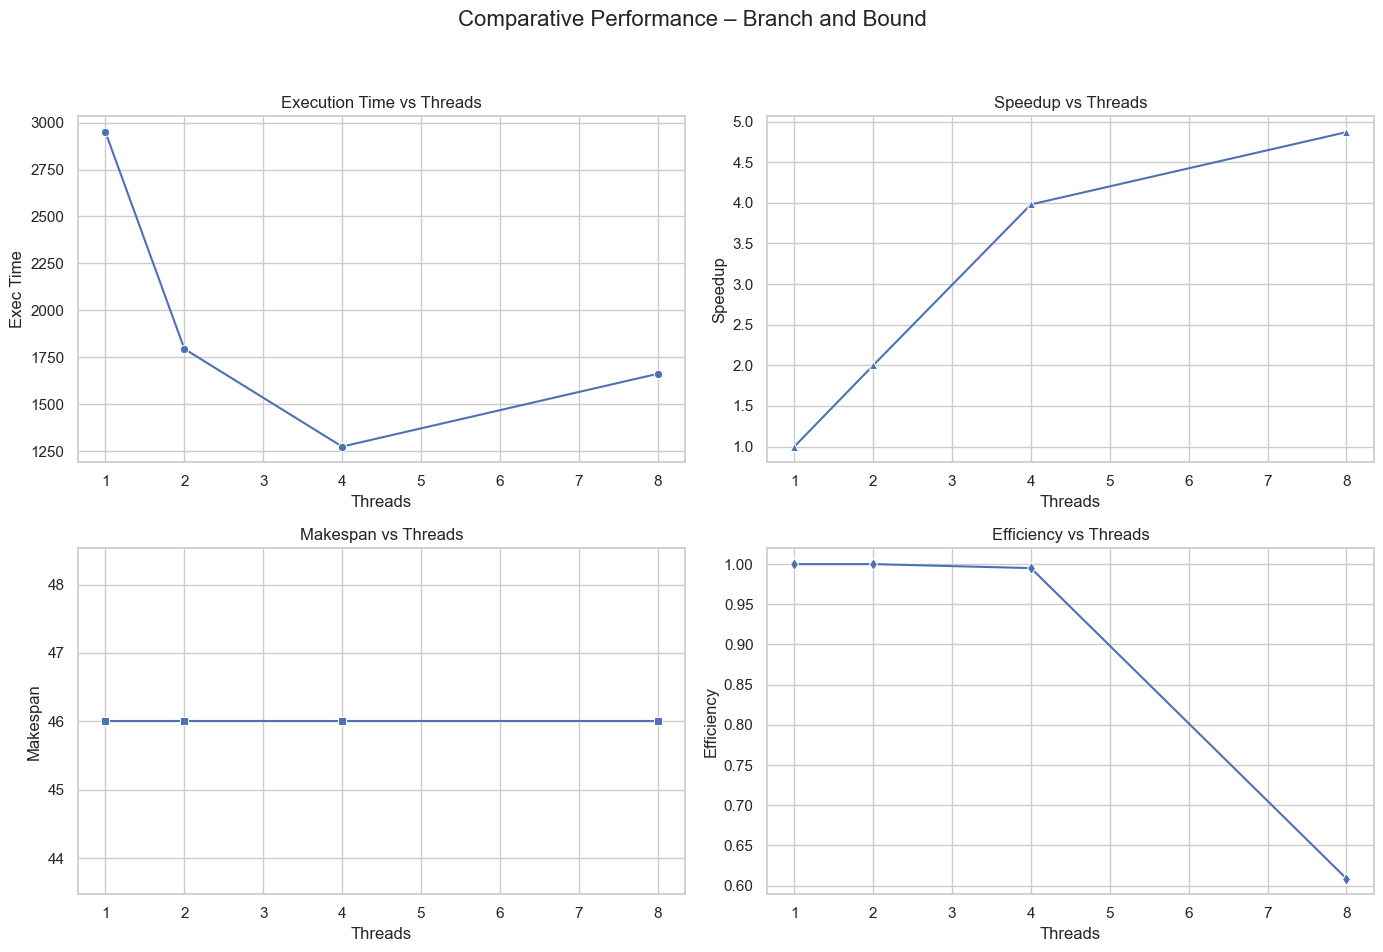

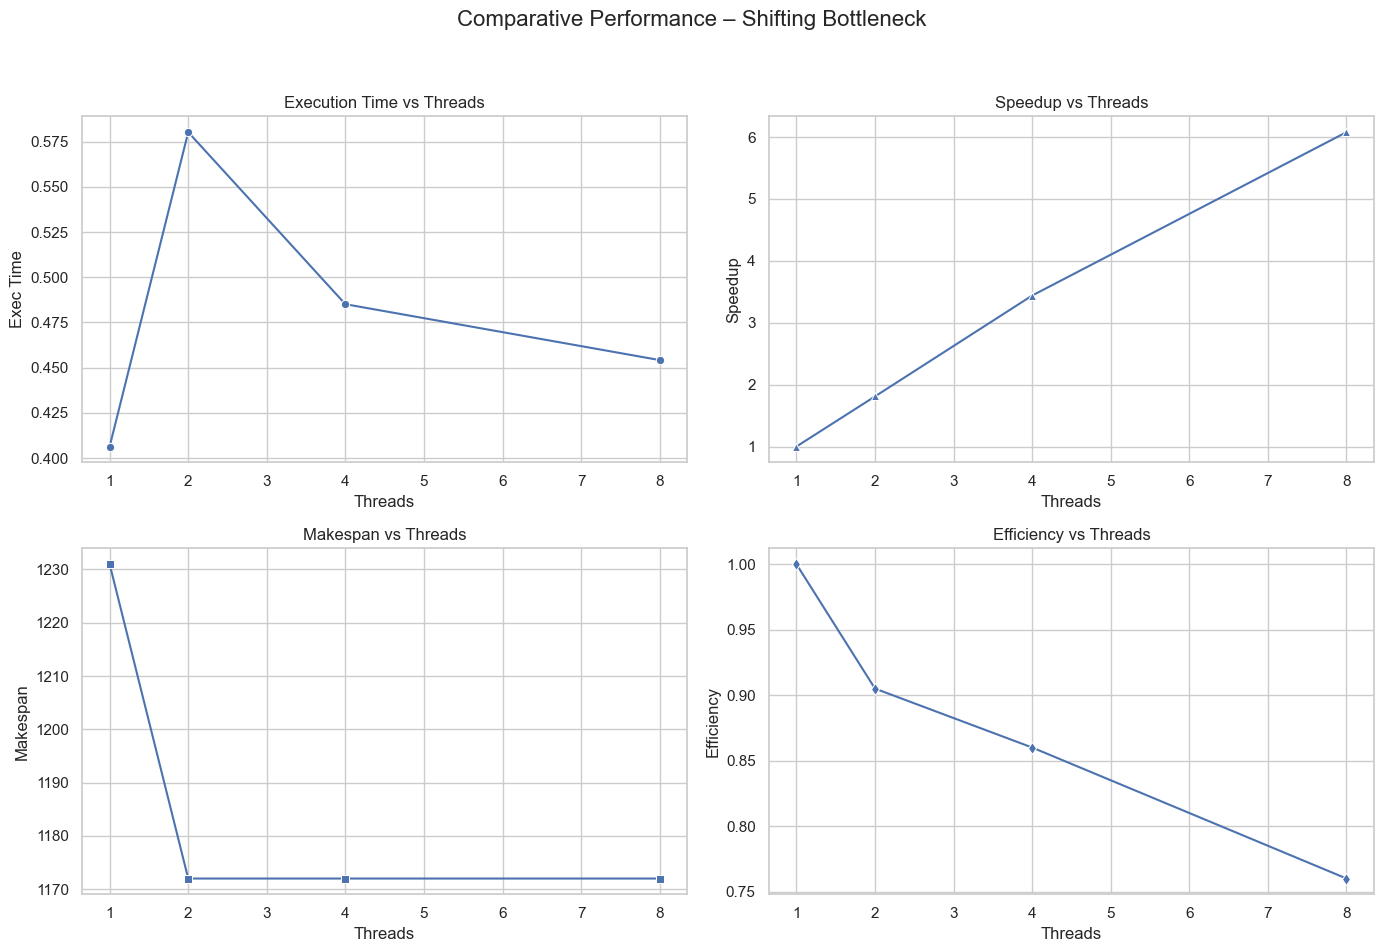

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from pathlib import Path
import os
from glob import glob

# === CONFIGURAÇÃO ===
base_dirs = ["../BnB/output", "../ShiftingBottleneck/output"]
file_pattern = "**/*metrics*.txt"
sns.set(style="whitegrid")

# === FUNÇÃO DE EXTRAÇÃO ===
def extract_metrics(filepath):
    with open(filepath, "r", encoding="utf-8") as file:
        text = file.read()

        def extract(regex, cast_func=str, default=None):
            match = re.search(regex, text)
            return cast_func(match.group(1)) if match else default

        return {
            "File": Path(filepath).name,
            "Path": str(filepath),
            "Input": extract(r"(Ficheiro|Arquivo) de entrada:\s*(.+)", str, "unknown"),
            "Algorithm": extract(r"Algoritmo:\s*(.+)", str, "unknown"),
            "Makespan": extract(r"Makespan:\s*(\d+)", int),
            "Exec Time (Wall)": extract(r"Tempo de execucao \(Wall\):\s*([\d.]+)", float),
            "Exec Time (CPU)": extract(r"Tempo de execucao \(CPU\):\s*([\d.]+)", float),
            "Exec Time (Single)": extract(r"Tempo de execucao:\s*([\d.]+)", float) if "Wall" not in text else None,
            "Threads": extract(r"Threads utilizadas:\s*(\d+)", int, 1),
            "Speedup": extract(r"Speedup:\s*([\d.]+)x", float, 1.0)
        }

# === LEITURA DOS FICHEIROS ===
data = []
for base_dir in base_dirs:
    files = glob(os.path.join(base_dir, file_pattern), recursive=True)
    for f in files:
        try:
            row = extract_metrics(f)
            if row["Algorithm"] != "unknown" and (row["Exec Time (Wall)"] or row["Exec Time (Single)"]):
                data.append(row)
            else:
                print(f"[Ignorado] {f}: dados insuficientes")
        except Exception as e:
            print(f"[Erro] {f}: {e}")

# === CRIAÇÃO E SEPARAÇÃO DO DATAFRAME ===
df = pd.DataFrame(data)
df["Threads"] = pd.to_numeric(df["Threads"], errors="coerce").fillna(1).astype(int)
df["Exec Time"] = df["Exec Time (Wall)"].combine_first(df["Exec Time (Single)"])
df["Efficiency"] = df["Speedup"] / df["Threads"]

# Agrupar algoritmo
df["Algorithm Group"] = df["Algorithm"].apply(
    lambda x: "Shifting Bottleneck" if "Shifting" in x else
              "Branch and Bound" if "Bound" in x else "Outro"
)

# Separar por grupo
df_bnb = df[df["Algorithm Group"] == "Branch and Bound"]
df_shift = df[df["Algorithm Group"] == "Shifting Bottleneck"]

# Exportar CSVs separados
df_bnb.to_csv("bnb_metrics.csv", index=False)
df_shift.to_csv("shifting_metrics.csv", index=False)
print(" Exportado: bnb_metrics.csv e shifting_metrics.csv")

# === FUNÇÃO DE GRÁFICOS POR GRUPO ===
def plot_group(df_group, group_name):
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f"Comparative Performance – {group_name}", fontsize=16)

    sns.lineplot(data=df_group, x="Threads", y="Exec Time", marker="o", ax=axes[0, 0])
    axes[0, 0].set_title("Execution Time vs Threads")

    sns.lineplot(data=df_group, x="Threads", y="Speedup", marker="^", ax=axes[0, 1])
    axes[0, 1].set_title("Speedup vs Threads")

    sns.lineplot(data=df_group, x="Threads", y="Makespan", marker="s", ax=axes[1, 0])
    axes[1, 0].set_title("Makespan vs Threads")

    sns.lineplot(data=df_group, x="Threads", y="Efficiency", marker="d", ax=axes[1, 1])
    axes[1, 1].set_title("Efficiency vs Threads")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig.savefig(f"comparative_performance_{group_name.lower().replace(' ', '_')}.png")
    plt.show()

# === GERAÇÃO DE GRÁFICOS ===
plot_group(df_bnb, "Branch and Bound")
plot_group(df_shift, "Shifting Bottleneck")


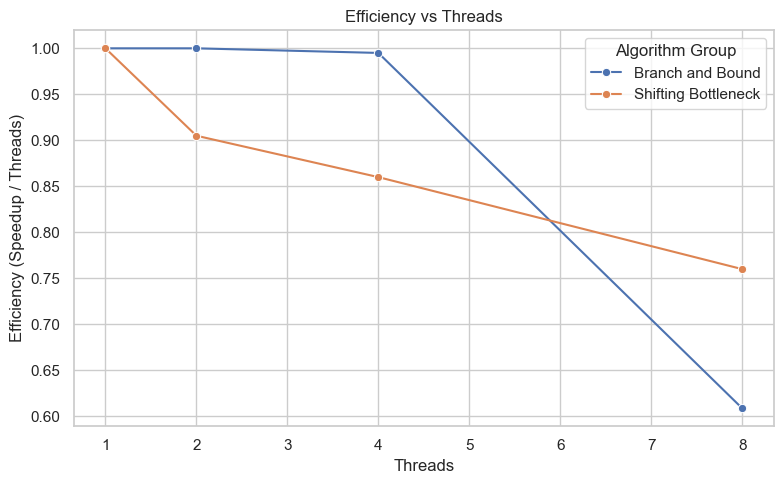

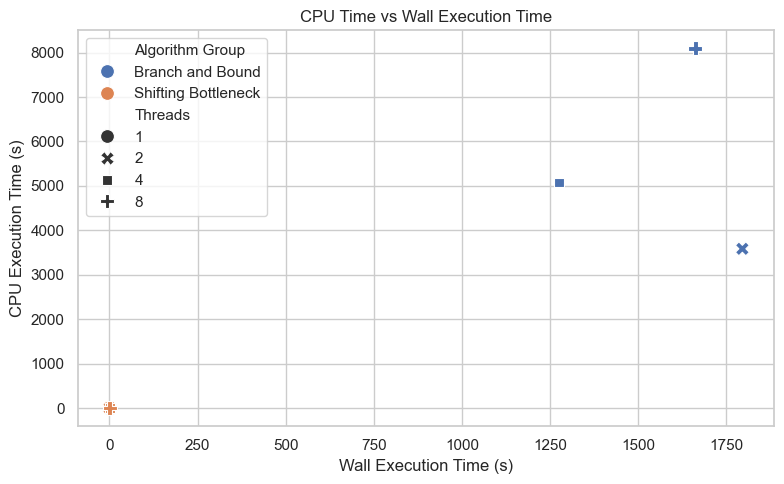

C:\Users\Utilizador\AppData\Local\Temp\ipykernel_14476\1110583250.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x="Algorithm Group", y="Makespan", estimator="mean", errorbar="sd", palette="muted")


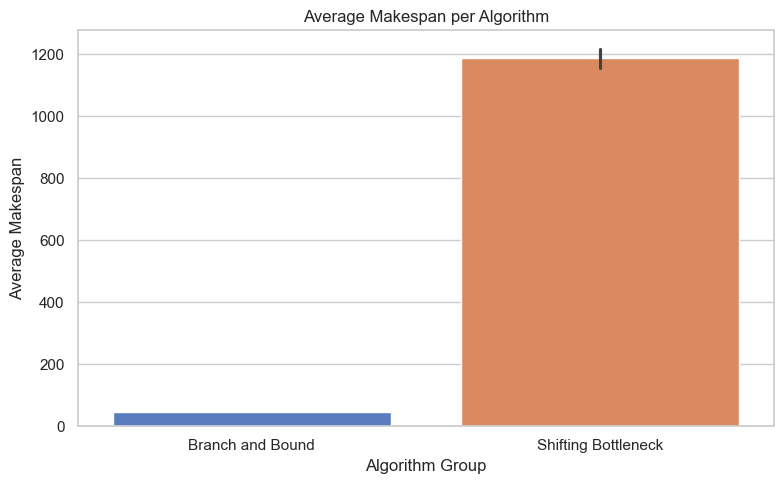

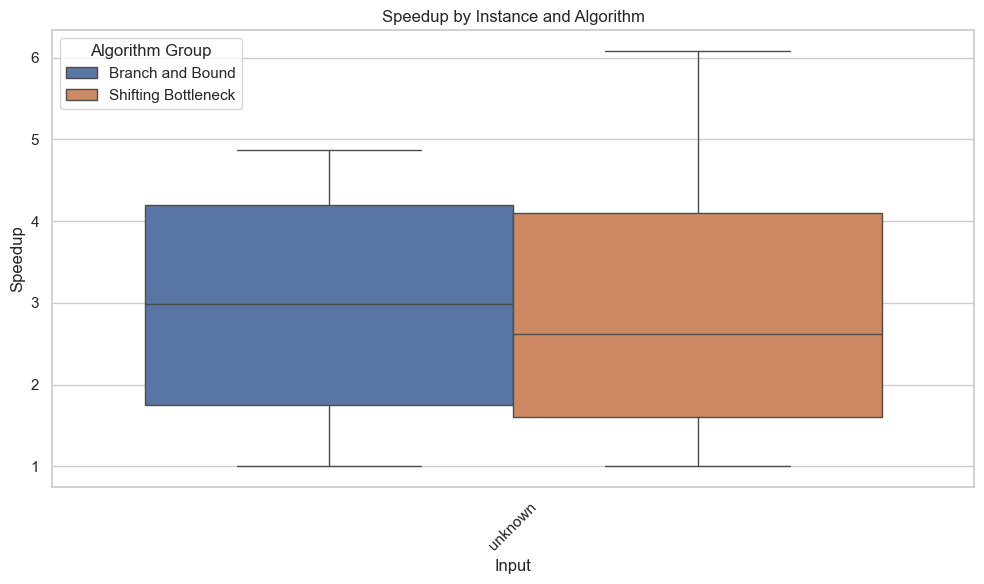

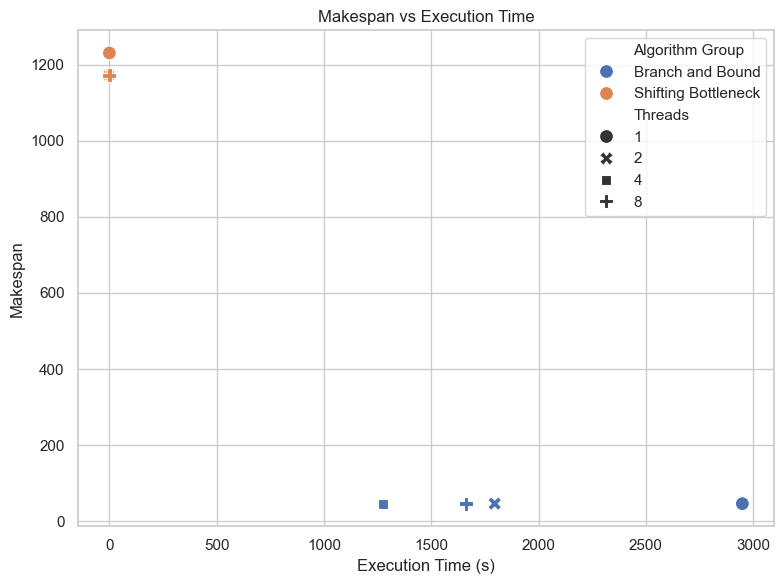

 Todos os gráficos foram gerados e guardados como imagens.


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === CONFIGURAÇÃO INICIAL ===
sns.set(style="whitegrid")
csv_path = "metrics_summary.csv"

# === LEITURA E PREPARAÇÃO DOS DADOS ===
df = pd.read_csv(csv_path)
df["Threads"] = pd.to_numeric(df["Threads"], errors="coerce").fillna(1).astype(int)
df["Exec Time"] = df["Exec Time (Wall)"].combine_first(df["Exec Time (Single)"])
df["Algorithm Group"] = df["Algorithm"].apply(
    lambda x: "Shifting Bottleneck" if "Shifting" in x else
              "Branch and Bound" if "Bound" in x else "Outro"
)
df["Efficiency"] = df["Speedup"] / df["Threads"]

# Corrigir entradas 'Arquivo' se possível
df["Input"] = df["Input"].replace("Arquivo", "unknown")

# === GERAÇÃO DOS GRÁFICOS ===

# 1. Eficiência vs Threads
plt.figure(figsize=(8, 5))
sns.lineplot(data=df, x="Threads", y="Efficiency", hue="Algorithm Group", marker="o")
plt.title("Efficiency vs Threads")
plt.ylabel("Efficiency (Speedup / Threads)")
plt.tight_layout()
plt.savefig("efficiency_vs_threads.png")
plt.show()

# 2. CPU vs Wall Time
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x="Exec Time", y="Exec Time (CPU)", hue="Algorithm Group", style="Threads", s=100)
plt.title("CPU Time vs Wall Execution Time")
plt.xlabel("Wall Execution Time (s)")
plt.ylabel("CPU Execution Time (s)")
plt.tight_layout()
plt.savefig("cpu_vs_wall.png")
plt.show()

# 3. Average Makespan per Algorithm
plt.figure(figsize=(8, 5))
sns.barplot(data=df, x="Algorithm Group", y="Makespan", estimator="mean", errorbar="sd", palette="muted")
plt.title("Average Makespan per Algorithm")
plt.ylabel("Average Makespan")
plt.tight_layout()
plt.savefig("avg_makespan.png")
plt.show()

# 4. Speedup per Instance
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="Input", y="Speedup", hue="Algorithm Group")
plt.title("Speedup by Instance and Algorithm")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("speedup_per_instance.png")
plt.show()

# 5. Execution Time vs Makespan
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x="Exec Time", y="Makespan", hue="Algorithm Group", style="Threads", s=100)
plt.title("Makespan vs Execution Time")
plt.xlabel("Execution Time (s)")
plt.ylabel("Makespan")
plt.tight_layout()
plt.savefig("makespan_vs_exec_time.png")
plt.show()

print(" Todos os gráficos foram gerados e guardados como imagens.")
